
Initial Predictions: [0 0 0 0]
Ground Truth: [0 1 0 1]


Epoch 0 Loss: 0.6994
Epoch 1000 Loss: 0.3311
Epoch 2000 Loss: 0.1707
Epoch 3000 Loss: 0.1224
Epoch 4000 Loss: 0.1015
Epoch 5000 Loss: 0.0911
Epoch 6000 Loss: 0.0852
Epoch 7000 Loss: 0.0816
Epoch 8000 Loss: 0.0792
Epoch 9000 Loss: 0.0776

Final Predictions: [0 1 0 1]
Ground Truth: [0 1 0 1]


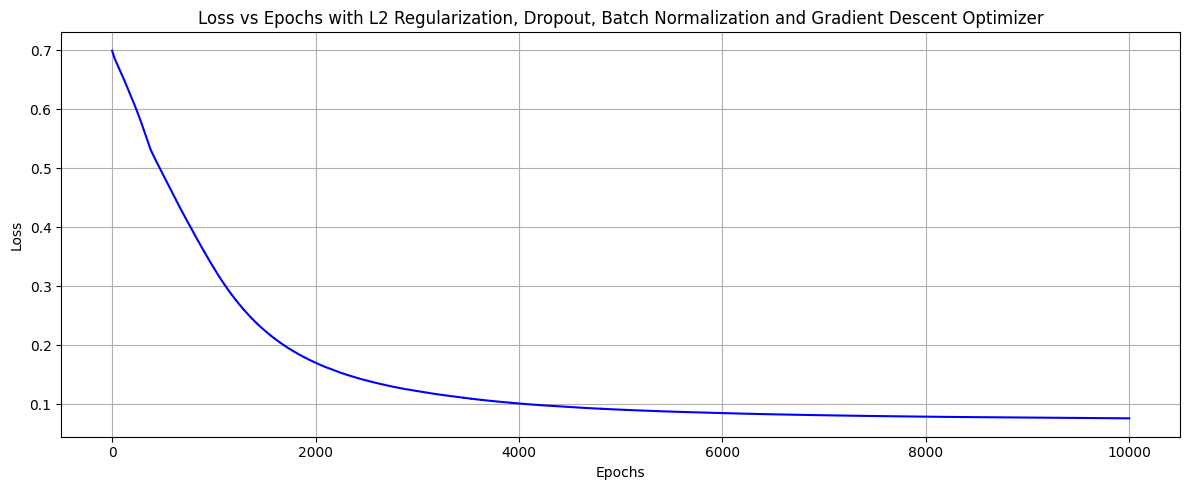

In [26]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0], [1,0], [1,1], [0,1]])  # shape (4,2)
Y = np.array([[0], [1], [0], [1]])          # shape (4,1)

np.random.seed(42)  # reproducibility

W1 = np.random.randn(2, 4)
b1 = np.random.randn(1, 4)

W2 = np.random.randn(4, 4)
b2 = np.zeros((1, 4))

W3 = np.random.randn(4, 1)
b3 = np.zeros((1, 1))

epochs = 10000
learning_rate = 0.01
l2_lambda  = 0.001 # For L2 Regularization
dropout_rate = 0.2 # 20% neuron dropout during training

#Batch Normalization
scale = np.ones((1,4))
shift = np.zeros((1,4))
constant = np.exp(-5)
losses = []

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def batch_normalization(x):
  mean = np.mean(x, axis=0, keepdims=True)
  var = np.var(x, axis=0, keepdims=True)
  x_batch = (x - mean) / np.sqrt(var + constant)
  x = scale * x_batch + shift
  return x

def forward_propagation(X, W1, b1, W2, b2, W3, b3, train=True):
    Z1 = np.dot(X, W1) + b1
    Z1_bn = batch_normalization(Z1)
    A1 = relu(Z1_bn)
    if train:
      D1 = np.random.rand(*A1.shape) > dropout_rate
      A1 = A1 * D1
      A1 = A1 / (1 - dropout_rate)
    else:
      D1 = np.ones_like(A1)
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    if train:
      D2 = np.random.rand(*A2.shape) > dropout_rate
      A2 = A2 * D2
      A2 = A2 / (1 - dropout_rate)
    else:
      D2 = np.ones_like(A2)

    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)

    cache = (X, Z1_bn, A1, D1, Z2, A2, D2, Z3, A3)
    return A3, cache

def compute_loss(Y, A3, W1, W2, W3):
  # Loss computed with L2 Regularization
    m = Y.shape[0]
    loss = - (np.sum(Y * np.log(A3) + (1 - Y) * np.log(1 - A3))) / m
    l2_penalty = l2_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    return loss + l2_penalty

def backward_propagation(Y, cache, W1, W2, W3):
    X, Z1_bn, A1, D1, Z2, A2, D2, Z3, A3 = cache
    m = Y.shape[0]

    #dZ3 = loss * sigmoid_derivative(A3)
    dZ3 = A3 - Y
    dW3 = np.dot(A2.T, dZ3) / m + l2_lambda  * W3 # With L2 loss regularization
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    dZ2 = np.dot(dZ3, W3.T) * relu_derivative(Z2)
    dZ2 = dZ2 * D2 / (1 - dropout_rate)
    dW2 = np.dot(A1.T, dZ2) / m + l2_lambda  * W2 # With L2 loss regularization
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1_bn)
    dZ1 = dZ1 * D1 / (1 - dropout_rate)
    dW1 = np.dot(X.T, dZ1) / m + l2_lambda  * W1 # With L2 loss regularization
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    gradients = (dW1, db1, dW2, db2, dW3, db3)
    return gradients

def update_parameters(W1, b1, W2, b2, W3, b3, gradients, lr):
    dW1, db1, dW2, db2, dW3, db3 = gradients
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    W3 -= lr * dW3
    b3 -= lr * db3
    return W1, b1, W2, b2, W3, b3

final_output, _ = forward_propagation(X, W1, b1, W2, b2, W3, b3, train=False)
predictions = (final_output > 0.5).astype(int)
print("\nInitial Predictions:", predictions.flatten())
print("Ground Truth:", Y.flatten())
print("\n")
for epoch in range(epochs):
    A3, cache = forward_propagation(X, W1, b1, W2, b2, W3, b3, train=False)
    loss = compute_loss(Y, A3, W1, W2, W3)
    losses.append(loss)
    gradients = backward_propagation(Y, cache, W1, W2, W3)
    W1, b1, W2, b2, W3, b3 = update_parameters(W1, b1, W2, b2, W3, b3, gradients, learning_rate)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} Loss: {loss:.4f}")
final_output, _ = forward_propagation(X, W1, b1, W2, b2, W3, b3, train=False)
predictions = (final_output > 0.5).astype(int)
print("\nFinal Predictions:", predictions.flatten())
print("Ground Truth:", Y.flatten())

plt.figure(figsize=(12,5))
plt.plot(losses, color='blue')
plt.title("Loss vs Epochs with L2 Regularization, Dropout, Batch Normalization and Gradient Descent Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
